# Machine learning for Power System Stability Analysis

<p style="background-color:azure;padding:10px;border:2px solid lightsteelblue"><b>Author:</b> Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)
<br>
University of Split, FESB, Department of Power Engineering <br>R. Boskovica 32, HR-21000 Split, Croatia, EU.</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

In [3]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

In [4]:
import keras

Using TensorFlow backend.


In [5]:
import warnings

In [6]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [7]:
# Inline figures
%matplotlib inline

In [8]:
# Figure aesthetics
sns.set(context='notebook', style='white', font_scale=1.1)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [9]:
# ancilary function from: https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/tools.py
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", fontsize=14):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", fontsize=fontsize)
    return img

### Power System Transient Stability Analysis Data (IEEE Benchmark Test Case)

In [10]:
data = pd.read_csv('GridDictionary.csv')
data.head()

,WmG1,WmG2,WmG3,WmG4,WmG5,WmG6,WmG7,WmG8,WmG9,WmG10,...,VClvB35,VAlvB36,VClvB36,VAlvB37,VClvB37,VAlvB38,VClvB38,VAlvB39,VClvB39,Stability
0,1.00120,1.0036,1.0029,1.0056,1.0079,1.0061,1.0060,1.0024,1.0025,1.0043,...,0.99777,1.03670,1.03670,1.0650,1.0650,1.0936,1.0936,1.0191,1.0191,0
1,1.00110,1.0033,1.0025,1.0047,1.0068,1.0052,1.0051,1.0021,1.0022,1.0039,...,1.01680,1.05330,1.05330,1.0673,1.0673,1.0922,1.0922,1.0192,1.0192,0
2,1.00120,1.0038,1.0033,1.0063,1.0079,1.0124,1.0114,1.0029,1.0030,1.0046,...,0.81049,0.88406,0.88378,1.0322,1.0322,1.0796,1.0796,1.0081,1.0081,0
3,1.00090,1.0025,1.0018,1.0011,1.0023,1.0015,1.0014,1.0012,1.0011,1.0020,...,1.07040,1.08570,1.08570,1.0570,1.0570,1.0676,1.0676,1.0252,1.0252,0
4,0.99983,1.0003,1.0007,1.0008,1.0008,1.0010,1.0009,1.0006,1.0010,1.0009,...,1.00710,1.01330,1.01330,1.0053,1.0053,1.0111,1.0111,1.0003,1.0003,0


In [9]:
#print(data.columns.values)

In [11]:
# Percentage of "ones" in the "Stability" column
print('There is {:.1f}% of unstable cases in the dataset!'.format(data['Stability'].sum()/float(len(data['Stability']))*100.))

There is 19.1% of unstable cases in the dataset!


### Select a random subset of the original data

In [11]:
# Select a random subset of the original dataset (without replacement)
#SUBSET_SIZE = 2000
#random_idx = np.random.choice(data.index, size=SUBSET_SIZE, replace=False)
#data = data.iloc[random_idx]

### Data preprocessing and splitting

In [12]:
# Training dataset
no_features = len(data.columns) - 1
X_data = data.iloc[:,0:no_features]  # features
print('X_data', X_data.shape)
y_data = data['Stability']
print('y_data', y_data.shape)

X_data (3120, 276)
y_data (3120,)


In [13]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, shuffle=True)

In [14]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (2496, 276)
y_train (2496,)
X_test (624, 276)
y_test (624,)


In [15]:
print('Unstable cases in training dataset: {:.1f}%:'.format(np.sum(y_train)/float(len(y_train))*100.))
print('Unstable cases in testing dataset {:.1f}%:'.format(np.sum(y_test)/float(len(y_test))*100.))

Unstable cases in training dataset: 19.0%:
Unstable cases in testing dataset 19.2%:


In [16]:
print('Unstable cases in training dataset: {:.1f}%:'.format(np.sum(y_train)/float(len(y_train))*100.))
print('Unstable cases in testing dataset {:.1f}%:'.format(np.sum(y_test)/float(len(y_test))*100.))

Unstable cases in training dataset: 19.0%:
Unstable cases in testing dataset 19.2%:


In [17]:
y_t = data[['Stability']].copy()
idx = y_test.index.values
y_t = y_t.loc[idx]
y_t.shape

(624, 1)

#### StandardScaler

In [18]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### LogisticRegression

In [20]:
# Grid-search with cross validation for optimal model hyper-parameters
parameters = {'C':[1., 10., 50., 100., 500., 1000.]}
lreg = GridSearchCV(estimator=LR(multi_class='auto', solver='newton-cg', 
                                 class_weight='balanced'),  # class balancing
                    param_grid=parameters, cv=3, scoring='f1',  # notice the "scoring" method!
                    refit=True, n_jobs=-1, iid=False)
# In this case GridSearchCV uses StratifiedKFold (with cv=3 folds) when
# the estimator is a classifier and y is either binary or multiclass!
lreg.fit(X_train, y_train)
# Best value of hyper-parameter "C"
best_c = lreg.best_params_['C']
print('Best value: C = {:g}'.format(best_c))

Best value: C = 500


In [21]:
# Average classification accuracy with cross validation
scores = cross_val_score(lreg, X_train, y_train, cv=3, scoring='f1')  # it does not return a model!
print('Score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Score using 3-fold CV: 0.974968 +/- 0.00738511


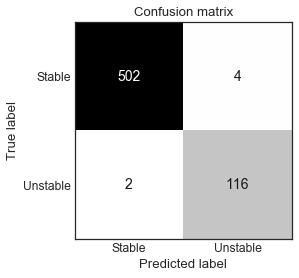

In [22]:
pred = lreg.predict(X_test)
labels = ['Stable', 'Unstable']
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, pred), xlabel='Predicted label', 
                       ylabel='True label', xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [23]:
# classification report
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      0.99      0.99       506
    Unstable       0.97      0.98      0.97       118

    accuracy                           0.99       624
   macro avg       0.98      0.99      0.98       624
weighted avg       0.99      0.99      0.99       624



In [24]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Values'])

,Values
accuracy,0.990385
recall,0.983051
precision,0.966667
roc_auc_score,0.987573


### Principal components analysis

In [22]:
# Let's first reduce all features in the dataset down to 3 principal components.
pca = PCA(n_components=3)
X3_train = pca.fit_transform(X_train)
X3_test = pca.transform(X_test)
idx_stable = y_test==0

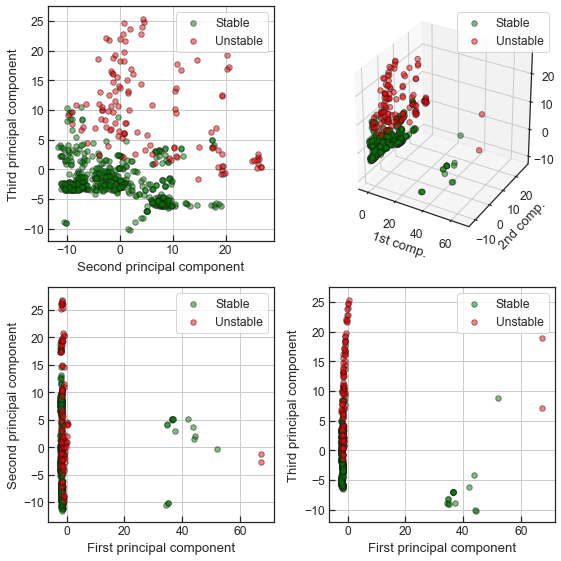

In [23]:
# Let's see what it looks like
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(221)
ax0.scatter(X3_test[idx_stable,1], X3_test[idx_stable,2], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax0.scatter(X3_test[~idx_stable,1], X3_test[~idx_stable,2], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax0.legend(loc='upper right')
ax0.set_xlabel('Second principal component')
ax0.set_ylabel('Third principal component')
ax0.grid()
ax1 = fig.add_subplot(222, projection='3d')
ax1.scatter(X3_test[idx_stable,0], X3_test[idx_stable,1], X3_test[idx_stable,2], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax1.scatter(X3_test[~idx_stable,0], X3_test[~idx_stable,1], X3_test[~idx_stable,2],
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax1.legend(loc='upper right')
ax1.set_xlabel('1st comp.')
ax1.set_ylabel('2nd comp.')
#ax1.set_zlabel('3rd comp.')
ax0 = fig.add_subplot(223)
ax0.scatter(X3_test[idx_stable,0], X3_test[idx_stable,1], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax0.scatter(X3_test[~idx_stable,0], X3_test[~idx_stable,1], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax0.legend(loc='upper right')
ax0.set_xlabel('First principal component')
ax0.set_ylabel('Second principal component')
ax0.grid()
ax0 = fig.add_subplot(224)
ax0.scatter(X3_test[idx_stable,0], X3_test[idx_stable,2], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax0.scatter(X3_test[~idx_stable,0], X3_test[~idx_stable,2], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax0.legend(loc='upper right')
ax0.set_xlabel('First principal component')
ax0.set_ylabel('Third principal component')
ax0.grid()
fig.tight_layout()
plt.savefig('PCA-3D.png', dpi=600)
plt.show()

In [27]:
# Average LR accuracy with only three principal components as features
scores = cross_val_score(LR(C=best_c, multi_class='ovr', solver='newton-cg', 
                            class_weight='balanced'), 
                         X3_train, y_train, cv=3, scoring='f1')
print('Score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Score using 3-fold CV: 0.856169 +/- 0.01793


### Dimensionality reduction using KernelPCA

In [25]:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(X_test)

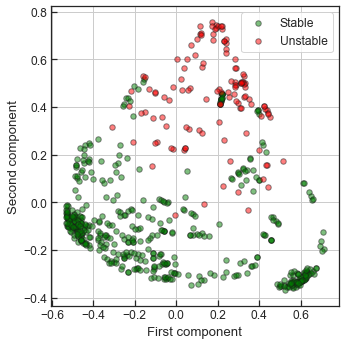

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_kpca[idx_stable,0], X_kpca[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_kpca[~idx_stable,0], X_kpca[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='best')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.grid()
fig.tight_layout()
plt.show()

### Autoencoder

In [28]:
# Reducing "no_features" to 2D space with autoencoder
input_layer = keras.layers.Input(shape=(no_features,))
# "encoded" is the encoded representation of the input
x = keras.layers.Dense(128, activation='relu', 
                       kernel_initializer='glorot_normal')(input_layer)
x = keras.layers.Dense(64, activation='relu', 
                       kernel_initializer='glorot_normal')(x)
encoded = keras.layers.Dense(2, activation='relu', 
                             kernel_initializer='glorot_normal')(x)
# "decoded" is the lossy reconstruction of the input
x = keras.layers.Dense(64, activation='relu', 
                       kernel_initializer='glorot_normal')(encoded)
x = keras.layers.Dense(128, activation='relu', 
                       kernel_initializer='glorot_normal')(x)
decoded = keras.layers.Dense(no_features, activation='linear', 
                             kernel_initializer='glorot_normal')(x)
# Autoencoder
autoencoder = keras.models.Model(input_layer, decoded)
# Encoder
encoder = keras.models.Model(input_layer, encoded)
# Compile the model
autoencoder.compile(optimizer='adadelta', loss='kullback_leibler_divergence')
# Define early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, 
                          shuffle=True, validation_split=0.1, 
                          callbacks=[early_stopping], verbose=0)

Epoch 00020: early stopping


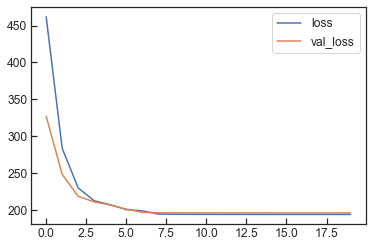

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [30]:
encoded_data = encoder.predict(X_test)

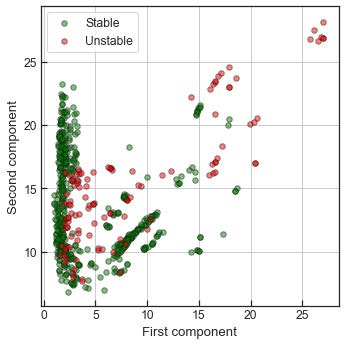

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(encoded_data[idx_stable,0], encoded_data[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(encoded_data[~idx_stable,0], encoded_data[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='best')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.grid()
fig.tight_layout()
plt.savefig('Autoencode2D.png', dpi=600)
plt.show()

### Dimensionality reduction using truncated SVD

In [32]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_test)

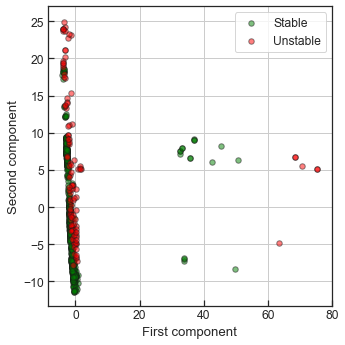

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_svd[idx_stable,0], X_svd[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_svd[~idx_stable,0], X_svd[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='best')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.grid()
fig.tight_layout()
plt.show()

### t-distributed Stochastic Neighbor Embedding

In [34]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_test)

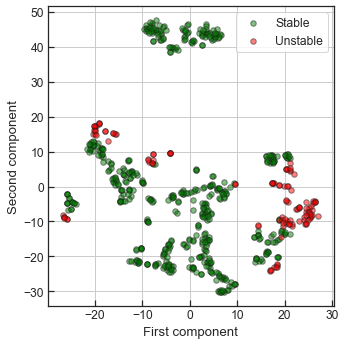

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_embedded[idx_stable,0], X_embedded[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_embedded[~idx_stable,0], X_embedded[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='best')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.grid()
fig.tight_layout()
plt.show()

#### Feature selection with Pipeline and GridSearch

In [30]:
# Optimize the number of features and the classifier's hyper-parameters 
# at the same time, using pipline and grid search with cross-validation
pca = PCA()  # do NOT set "n_components" here!
logreg = LR(multi_class='ovr', solver='newton-cg', class_weight='balanced') 
pipe = Pipeline([('pca',pca), ('logreg',logreg)])
param_grid = {'pca__n_components': [10, 20, 30, 50, 100],   # PCA
              'logreg__C': [1., 10., 50., 100.]}      # LogisticRegression
grid_pipe = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, 
                         scoring='f1', refit=True, n_jobs=-1, iid=False)
grid_pipe.fit(X_train, y_train)
print('Best parameter (CV score = {:0.3f}):'.format(grid_pipe.best_score_))
print(grid_pipe.best_params_)

Best parameter (CV score = 0.982):
{'logreg__C': 100.0, 'pca__n_components': 50}


In [31]:
# Predict probability on test data
y_lr = grid_pipe.predict_proba(X_test)
y_t['logreg'] = y_lr.argmax(axis=1)

### Support Vector Machine

In [32]:
parameters ={'C':[1., 10., 100., 500., 1000.],
             'gamma':[0.0001, 0.001, 0.01, 0.1, 1.]}
svc = GridSearchCV(estimator=svm.SVC(kernel='rbf', probability=True, 
                                     class_weight='balanced'),  # class balancing
                   param_grid=parameters, cv=3,
                   scoring='f1', refit=True, n_jobs=-1, iid=False)
svc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1.0, 10.0, 100.0, 500.0, 1000.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [33]:
# Best model parameters
best_parameters = svc.best_params_
print("Best parameters from GridSearch: {}".format(svc.best_params_))

Best parameters from GridSearch: {'C': 500.0, 'gamma': 0.01}


In [34]:
scores = cross_val_score(svc, X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.979562 +/- 0.0112555


In [35]:
results = pd.DataFrame(svc.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(parameters['C']), len(parameters['gamma']))

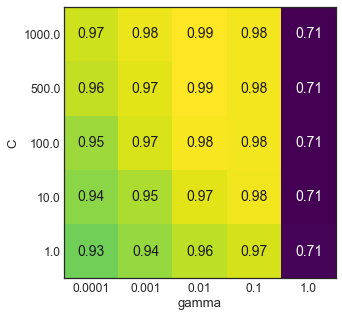

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
heatmap(scores, xlabel='gamma', xticklabels=parameters['gamma'], 
        ylabel='C', yticklabels=parameters['C'], cmap="viridis", ax=ax)
plt.show()

#### RandomizedSearchCV

In [37]:
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc2 = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True, 
                                            class_weight='balanced'), 
                          param_distributions=parameters, cv=3, n_iter=50,  # 50 iterations!
                          scoring='f1',  # notice the scoring method!
                          refit=True, n_jobs=-1, iid=False)
svc2.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f14181529b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1418152a58>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [38]:
# Best model parameters
best_parameters = svc2.best_params_
print("Best parameters from RandomSearch: {}".format(svc2.best_params_))

Best parameters from RandomSearch: {'C': 269.9828538301133, 'gamma': 0.012973841097631101}


In [39]:
scores = cross_val_score(svc2, X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.978549 +/- 0.00998792


In [40]:
# classification report
pred = svc2.predict(X_test)
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       518
    Unstable       0.98      1.00      0.99       106

    accuracy                           1.00       624
   macro avg       0.99      1.00      0.99       624
weighted avg       1.00      1.00      1.00       624



In [41]:
y_svc2 = svc2.predict_proba(X_test)
y_t['svc'] = y_svc2.argmax(axis=1)

#### Precision-Recall Tradeoff

In [42]:
y_probas = cross_val_predict(svm.SVC(**best_parameters, probability=True, class_weight='balanced'), 
                             X_train, y_train, cv=3, method='predict_proba')

In [43]:
y_scores = y_probas[:,1]  # score == probability of positive class
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores)

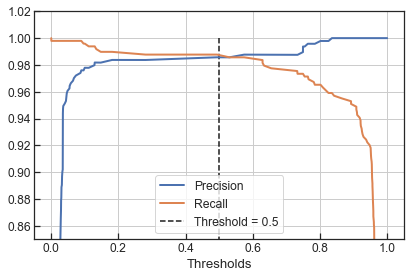

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
#ax.set_title('SVM Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.set_ylim(bottom=0.85, top=1.02)
ax.grid()
fig.tight_layout()
plt.savefig('SVM-Precision-Recall.png', dpi=600)
plt.show()

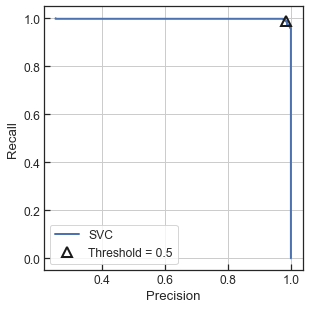

In [45]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.plot(precisions, recalls, lw=2, label='SVC')
default = np.argmin(np.abs(thresholds - 0.5))
ax.plot(precisions[default], recalls[default], '^', c='k', markersize=10, 
        label='Threshold = 0.5', fillstyle='none', mew=2)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(loc='best')
ax.grid()
fig.tight_layout()
plt.show()

In [46]:
# Average precision-recall score
y_test_score = svc2.predict_proba(X_test)[:,1]
average_precision = metrics.average_precision_score(y_test, y_test_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


In [48]:
# Determine a class from the predicted probability by using 
# the user-specified threshold value (not a default of 0.5)
THRESHOLD = 0.52  # Example
preds = np.where(y_test_score > THRESHOLD, 1, 0)

In [49]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Values'])

,Values
accuracy,0.996795
recall,1.000000
precision,0.981481
roc_auc_score,0.998069


### ExtraTreesClassifier

In [50]:
# ExtraTreesClassifier (ensemble learner) with grid search 
# and cross-validation for hyper-parameters optimisation
parameters = {'n_estimators':[5, 10, 15, 20], 
              'criterion':['gini', 'entropy'], 
              'max_depth':[2, 5, None]}
trees = GridSearchCV(estimator=ExtraTreesClassifier(class_weight='balanced'), param_grid=parameters, 
                     cv=3, scoring='f1', refit=True, n_jobs=-1, iid=False) 
trees.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False,
                                            class_weight='balanced',
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid=False, n_jobs=-1,


In [51]:
# Best model parameters
best_parameters = trees.best_params_
print("Best parameters: {}".format(trees.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 15}


In [52]:
scores = cross_val_score(trees, X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.981657 +/- 0.00895311


In [53]:
# classification report
pred = trees.predict(X_test)
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       518
    Unstable       0.99      0.98      0.99       106

    accuracy                           1.00       624
   macro avg       0.99      0.99      0.99       624
weighted avg       1.00      1.00      1.00       624



In [54]:
y_trees = trees.predict_proba(X_test)
y_t['tree'] = y_trees.argmax(axis=1)

#### Feature importance analysis

In [55]:
trees = ExtraTreesClassifier(**best_parameters, class_weight='balanced')
trees.fit(X_train, y_train)
trees_feature_importance = trees.feature_importances_
trees_feature_importance = 100.0 * (trees_feature_importance / trees_feature_importance.max())
sorted_idx_trees = np.argsort(trees_feature_importance)
position = np.arange(sorted_idx_trees.shape[0]) + .5

In [56]:
# Select top features considering their relative importance
# Top features are those above some preselect threshold of relative importance
IMPORTANCE = 20.  # relative importance threshold
TOPT = np.sum(trees_feature_importance[sorted_idx_trees] > IMPORTANCE)
print(TOPT)
top_features_trees = data.columns.values[sorted_idx_trees][-TOPT:][::-1]
print('Most relevant {:d} features according to the ExtraTreesClassifier:'.format(TOPT))
print(top_features_trees)

11
Most relevant 11 features according to the ExtraTreesClassifier:
['QlvG9' 'WmG9' 'QlvG7' 'QlvG6' 'IdG10' 'IqG9' 'QlvG4' 'IqG4' 'VtG3'
 'VtG4' 'IdG1']


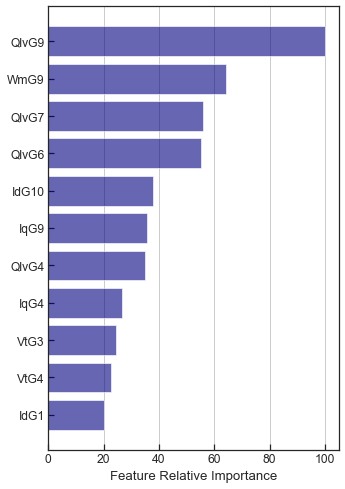

In [57]:
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(5,7))
ax.barh(position[-TOPT:], trees_feature_importance[sorted_idx_trees][-TOPT:], 
        align='center', color='navy', alpha=0.6)
plt.yticks(position[-TOPT:], data.columns[sorted_idx_trees][-TOPT:])
ax.set_xlabel('Feature Relative Importance')
ax.grid(which='major', axis='x')
plt.tight_layout()
plt.show()

### RandomForest classifier (ensemble learner)

In [58]:
# RandomForestClassifier (ensemble learner for classification)
parameters = {'n_estimators':[10, 15, 20], 
              'criterion':['gini', 'entropy'],
              'max_features':[4, 'auto'],
              'max_depth':[2, None]}
# grid search and cross-validation for hyper-parameters optimisation
forest = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=parameters, 
                      cv=3, scoring='f1', refit=True, n_jobs=-1, iid=False) 
forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [59]:
best_forest_parameters = forest.best_params_
print("Best parameters: {}".format(forest.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 15}


In [60]:
scores = cross_val_score(forest, X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.978536 +/- 0.0124322


In [61]:
# classification report
pred = forest.predict(X_test)
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       518
    Unstable       1.00      0.98      0.99       106

    accuracy                           1.00       624
   macro avg       1.00      0.99      0.99       624
weighted avg       1.00      1.00      1.00       624



In [62]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Values'])

,Values
accuracy,0.996795
recall,0.981132
precision,1.000000
roc_auc_score,0.990566


In [63]:
y_forest = forest.predict_proba(X_test)
y_t['forest'] = y_forest.argmax(axis=1)

In [64]:
forest_top = RandomForestClassifier(**best_forest_parameters, class_weight='balanced')
forest_top.fit(X_train, y_train)
forest_feature_importance = forest_top.feature_importances_
forest_feature_importance = 100.0 * (forest_feature_importance / forest_feature_importance.max())
sorted_idx_forest = np.argsort(forest_feature_importance)
position_forest = np.arange(sorted_idx_forest.shape[0]) + .5

In [65]:
FOPT = np.sum(forest_feature_importance[sorted_idx_forest] > IMPORTANCE)
top_features_forest = data.columns.values[sorted_idx_forest][-FOPT:][::-1]
print('Most relevant {:d} features according to the RandomForestClassifier:'.format(FOPT))
print(top_features_forest)

Most relevant 11 features according to the RandomForestClassifier:
['LAlvG6' 'IqG9' 'QlvG6' 'QlvG1' 'IqG7' 'VtG6' 'WmG9' 'LAlvG4' 'VtG5'
 'IdG2' 'QlvG9']


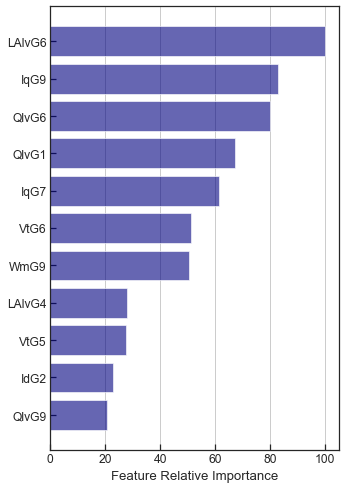

In [66]:
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(5,7))
ax.barh(position_forest[-FOPT:], forest_feature_importance[sorted_idx_forest][-FOPT:], 
        align='center', color='navy', alpha=0.6)
plt.yticks(position_forest[-FOPT:], data.columns[sorted_idx_forest][-FOPT:])
ax.set_xlabel('Feature Relative Importance')
ax.grid(which='major', axis='x')
plt.tight_layout()
plt.savefig('Forest-Features.png', dpi=600)
plt.show()

In [67]:
duplicate_features = set(top_features_trees).intersection(set(top_features_forest))
print(duplicate_features)

{'IqG9', 'WmG9', 'QlvG9', 'QlvG6'}


### GradientBoosting classifier with feature importance analysis

In [68]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y, ns=3):
    # k-fold cross validation iterator 
    cv = StratifiedKFold(n_splits=ns, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')  # scoring='f1'
    print('Average score using {:d}-fold CV: {:g} +/- {:g}'.format(ns, np.mean(scores), np.std(scores)))

In [69]:
# Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier()
train_and_evaluate(clf_gb, X_train, y_train, 3)
clf_gb.fit(X_train, y_train)

Average score using 3-fold CV: 0.984653 +/- 0.00440466


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [70]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [71]:
# Select top features
TOP = 10
top_features = data.columns.values[sorted_idx][-TOP:][::-1]
print('Most relevant {:d} features according to the GradientBoostingClassifier:'.format(TOP))
print(top_features)

Most relevant 10 features according to the GradientBoostingClassifier:
['IqG7' 'IqG9' 'IqG6' 'VtG5' 'PlvG6' 'IdG9' 'PlvG9' 'WmG7' 'QlvG6'
 'VAlvB11']


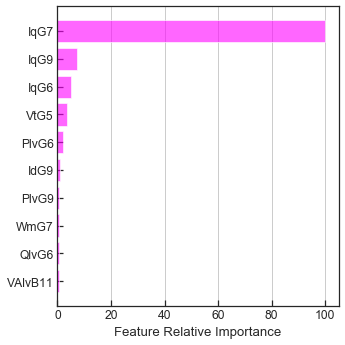

In [72]:
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(5,5))
ax.barh(pos[-TOP:], feature_importance[sorted_idx][-TOP:], align='center', color='magenta', alpha=0.6)
plt.yticks(pos[-TOP:], data.columns[sorted_idx][-TOP:])
ax.set_xlabel('Feature Relative Importance')
ax.grid(which='major', axis='x')
plt.tight_layout()
plt.show()

In [73]:
print(set(top_features_trees).intersection(set(top_features)))

{'IqG9', 'QlvG6'}


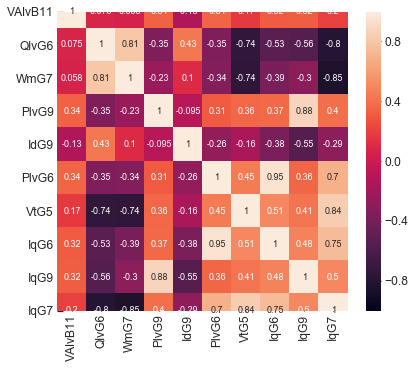

In [74]:
# Correlation matrix of selected features
pearson = data[data.columns[sorted_idx][-TOP:]].corr('pearson')
pearson.iloc[-1][:-1].sort_values()
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(6.5,5.5))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=9), vmin=-1, vmax=1, ax=ax)
#plt.tight_layout()
plt.show()

In [75]:
# classification report
pred = clf_gb.predict(X_test)
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       518
    Unstable       0.99      0.99      0.99       106

    accuracy                           1.00       624
   macro avg       0.99      0.99      0.99       624
weighted avg       1.00      1.00      1.00       624



In [76]:
# Predict on new data
y_gb = clf_gb.predict_proba(X_test)
y_t['gbr'] = y_gb.argmax(axis=1)

#### Re-train SVM using only top features from the GradientBoosting classifier

In [77]:
# IMPORTANT: NTOP <= TOP
NTOP = 2  # using only top 2 features!

In [78]:
top_features_index = []
for name in top_features:
    top_features_index.append(data.columns.get_loc(name))

In [79]:
X_train_best = X_train[:,top_features_index[:NTOP]]
X_test_best = X_test[:,top_features_index[:NTOP]]
print(X_train_best.shape)
print(X_test_best.shape)

(2496, 2)
(624, 2)


In [80]:
# Optimize SVM with only TOP features
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc_top = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True, class_weight='balanced'), 
                             param_distributions=parameters, cv=3, n_iter=100,  # 100 iterations!
                             scoring='f1',  # notice the scoring method!
                             refit=True, n_jobs=-1, iid=False)
svc_top.fit(X_train_best, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f140077d470>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f140077d5f8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [81]:
# Best model parameters
best_parameters = svc_top.best_params_
print("Best parameters from RandomSearch: {}".format(svc_top.best_params_))

Best parameters from RandomSearch: {'C': 29.369650944168797, 'gamma': 0.15568416476873448}


In [82]:
scores = cross_val_score(svc_top, X_train_best, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.930761 +/- 0.00814852


In [153]:
pred = svc_top.predict(X_test_best)
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred),
                   metrics.f1_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", 'f1-score'], columns=['Values'])

,Values
accuracy,0.964744
recall,0.990566
precision,0.833333
roc_auc_score,0.975013
f1-score,0.905172


#### Graphical visualization of the top two features

In [83]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [84]:
idx_stable = y_test==0

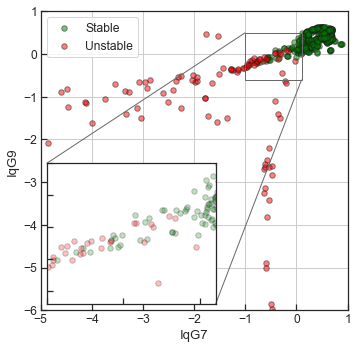

In [85]:
# Ploting data without standard scaler transformer
fig, ax = plt.subplots(figsize=(5.5,5.5))
ax.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_xlim(-5,1)
ax.set_ylim(-6,1)
ax.grid()
# Inset figure with a zoomed-in region of interest
axins = zoomed_inset_axes(ax, zoom=3, loc='lower left')
axins.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.25, label='Stable')
axins.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.25, label='Unstable')
axins.set_xlim(-1,0.1)
axins.set_ylim(-0.6,0.5)
plt.xticks(visible=False)
plt.yticks(visible=False)
# draw a box of the region of the inset axes in the parent axes 
# and connecting lines between the box and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='dimgrey')
plt.show()

#### Plot decision region for test samples with only top two features (NTOP = 2)

In [86]:
# Axis grid with NTOP = 2
h = 0.1; delta = 0.01
x_min, x_max = X_test_best[:,0].min() - h, X_test_best[:,0].max() + h
y_min, y_max = X_test_best[:,1].min() - h, X_test_best[:,1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
Z = svc_top.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

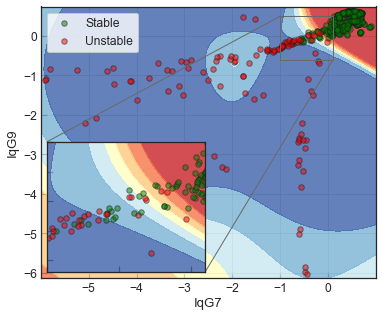

In [87]:
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
ax.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.grid()
# Inset figure with a zoomed-in region of interest
axins = zoomed_inset_axes(ax, zoom=3, loc='lower left')
axins.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
axins.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
axins.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
axins.set_xlim(-1,0.1)
axins.set_ylim(-0.6,0.5)
plt.xticks(visible=False)
plt.yticks(visible=False)
# draw a box of the region of the inset axes in the parent axes 
# and connecting lines between the box and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='dimgrey')
plt.savefig('SVM-TOP2Features.png', dpi=600)
plt.show()

### Principal components with best features from different learners

#### Unifying best features from different classifiers

In [88]:
print('Most relevant {:d} features according to the ExtraTreesClassifier:'.format(TOPT))
print(top_features_trees)
print('Most relevant {:d} features according to the RandomForestClassifier:'.format(FOPT))
print(top_features_forest)
top_features_all = set(top_features_trees).union(set(top_features_forest))
print('Union of most relevant features {:d}:'.format(len(top_features_all)))
print(top_features_all)
features_duplex = set(top_features_trees).intersection(set(top_features_forest))
print('Features selected by both classifiers {:d}:'.format(len(features_duplex)))
print(features_duplex)

Most relevant 11 features according to the ExtraTreesClassifier:
['QlvG9' 'WmG9' 'QlvG7' 'QlvG6' 'IdG10' 'IqG9' 'QlvG4' 'IqG4' 'VtG3'
 'VtG4' 'IdG1']
Most relevant 11 features according to the RandomForestClassifier:
['LAlvG6' 'IqG9' 'QlvG6' 'QlvG1' 'IqG7' 'VtG6' 'WmG9' 'LAlvG4' 'VtG5'
 'IdG2' 'QlvG9']
Union of most relevant features 18:
{'LAlvG6', 'VtG3', 'IdG1', 'QlvG7', 'QlvG6', 'IqG9', 'IqG7', 'QlvG1', 'IdG2', 'IdG10', 'QlvG4', 'QlvG9', 'VtG4', 'LAlvG4', 'VtG5', 'IqG4', 'WmG9', 'VtG6'}
Features selected by both classifiers 4:
{'IqG9', 'WmG9', 'QlvG9', 'QlvG6'}


In [89]:
top_features_index = []
for name in top_features_all:
    top_features_index.append(data.columns.get_loc(name))

In [155]:
# Projecting best features using only two principal components
pca = PCA(n_components=2, whiten=True)
X2_train = pca.fit_transform(X_train[:,top_features_index])
X2_test = pca.transform(X_test[:,top_features_index])

<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> The union of best (unique) features selected previously by the ExtraTrees and RandomForest classifiers are reduced down to the two principal components. This essentially means that the multi-dimensional space of original features is projected into the 2D space of principal components. Now, one can easily visualize test cases and novel decision boundary in this new 2D coordinate system of principal components.</p>

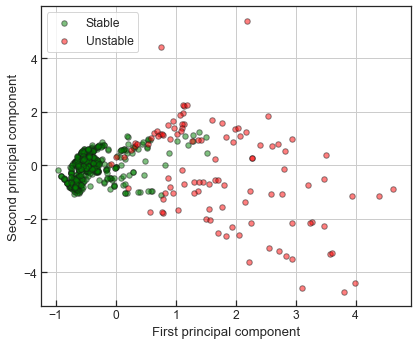

In [156]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(X2_test[idx_stable,0], X2_test[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X2_test[~idx_stable,0], X2_test[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.grid()
fig.tight_layout()
plt.show()

#### Train SVM classifier using principal components

In [157]:
# Optimize SVM with only TOP features
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc_pca = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True, class_weight='balanced'), 
                             param_distributions=parameters, cv=3, n_iter=50,  # iterations!
                             scoring='f1',  # notice the scoring method!
                             refit=True, n_jobs=-1, iid=False)
svc_pca.fit(X2_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f13d405acc0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f13c467fda0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [158]:
scores = cross_val_score(svc_pca, X2_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.83989 +/- 0.0224245


In [159]:
pred = svc_pca.predict(X2_test)
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred),
                   metrics.f1_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", 'f1-score'], columns=['Values'])

,Values
accuracy,0.939103
recall,0.962264
precision,0.750000
roc_auc_score,0.948314
f1-score,0.842975


In [160]:
h = 0.1; delta = 0.01
x_min, x_max = X2_test[:,0].min() - h, X2_test[:,0].max() + h
y_min, y_max = X2_test[:,1].min() - h, X2_test[:,1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
Z = svc_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

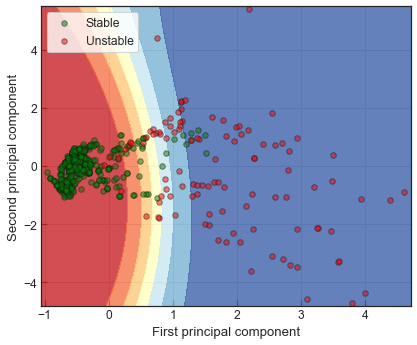

In [161]:
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
ax.scatter(X2_test[idx_stable,0], X2_test[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X2_test[~idx_stable,0], X2_test[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.grid()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
fig.tight_layout()
plt.savefig('SVM-PCA2D-BestFeatures.png', dpi=600)
plt.show()

## Ensemble models using voting principle

<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. The key to making ensembling work is the diversity of the set of classifiers. Diversity is what makes ensembling work. For this reason, one should ensemble models that are as good as possible while being <b>as different as possible</b>. This typically means using very different network architectures or even different brands of machine-learning approaches. This is exactly what has been proposed here.</p>

### Soft voting

In [96]:
clf = VotingClassifier(estimators=[('logreg', lreg),     # LogisticRegression
                                   ('svm', svc2),        # SVC
                                   ('forest', forest)],  # RandomForest 
                       weights=[1, 2, 1],  # classifier relative weights
                       voting='soft', n_jobs=-1)
clf.fit(X_train, y_train);  # train with a full set of features

VotingClassifier(estimators=[('logreg',
                              GridSearchCV(cv=3,
                                           error_score='raise-deprecating',
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight='balanced',
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                        

In [97]:
scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)  # scoring='f1'!
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.984659 +/- 0.00867197


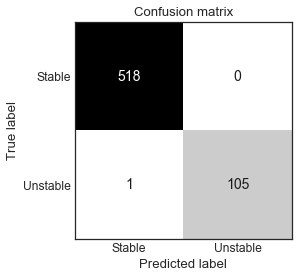

In [98]:
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, clf.predict(X_test)), 
                       xlabel='Predicted label', ylabel='True label', 
                       xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [99]:
# classification report
pred = clf.predict(X_test)
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       518
    Unstable       1.00      0.99      1.00       106

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



In [100]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Values'])

,Values
accuracy,0.998397
recall,0.990566
precision,1.000000
roc_auc_score,0.995283


In [101]:
y_clf = clf.predict_proba(X_test)
y_t['vote'] = y_clf.argmax(axis=1)

#### Voting by training classifiers with only best features

In [102]:
X_train_best_features = X_train[:,top_features_index]
X_test_best_features = X_test[:,top_features_index]
X_train_best_features.shape

(2496, 18)

In [103]:
lreg.fit(X_train_best_features, y_train);

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='newton-cg',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [104]:
scores = cross_val_score(lreg, X_train_best_features, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.978949 +/- 0.00486689


In [145]:
pred = lreg.predict(X_test_best_features)
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred),
                   metrics.f1_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score"], columns=['Values'])

,Values
accuracy,0.990385
recall,0.990566
precision,0.954545
roc_auc_score,0.990457
f1-score,0.972222


In [107]:
svc2.fit(X_train_best_features, y_train);

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f14181529b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1418152a58>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [108]:
scores = cross_val_score(svc2, X_train_best_features, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.987841 +/- 0.00648378


In [146]:
pred = svc2.predict(X_test_best_features)
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred),
                   metrics.f1_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", 'f1-score'], columns=['Values'])

,Values
accuracy,0.995192
recall,0.990566
precision,0.981308
roc_auc_score,0.993353
f1-score,0.985915


In [110]:
forest.fit(X_train_best_features, y_train);

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

In [111]:
scores = cross_val_score(forest, X_train_best_features, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.985735 +/- 0.00629187


In [147]:
pred = forest.predict(X_test_best_features)
pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), metrics.recall_score(y_test, pred),
                   metrics.precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred),
                   metrics.f1_score(y_test, pred)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score"], columns=['Values'])

,Values
accuracy,0.996795
recall,0.990566
precision,0.990566
roc_auc_score,0.994318
f1-score,0.990566


In [113]:
clf2 = VotingClassifier(estimators=[('logreg', lreg),   # LogisticRegression
                                    ('svm', svc2),      # SVC
                                    ('forest', forest)],  # RandomForest 
                        weights=[1, 2, 1],  # classifier relative weights
                        voting='soft', n_jobs=-1)
clf2.fit(X_train_best_features, y_train);  # train with selected features

VotingClassifier(estimators=[('logreg',
                              GridSearchCV(cv=3,
                                           error_score='raise-deprecating',
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight='balanced',
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                        

In [114]:
scores = cross_val_score(clf2, X_train_best_features, y_train, cv=3, scoring='f1', n_jobs=-1)  # scoring='f1'!
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.988768 +/- 0.00626913


In [115]:
# classification report
pred = clf2.predict(X_test_best_features)
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00       518
    Unstable       0.99      1.00      1.00       106

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



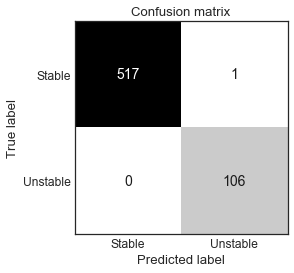

In [163]:
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, clf2.predict(X_test_best_features)), 
                       xlabel='Predicted label', ylabel='True label', 
                       xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Confusion-Matrix.png', dpi=600)
plt.show()

#### Final Calibration

In [117]:
y_test_probas = clf2.predict_proba(X_test_best_features)
y_test_scores = y_test_probas[:,1]  # score == probability of positive class
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_scores)

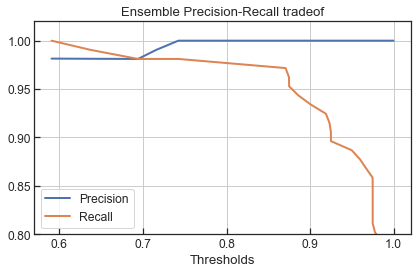

In [144]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('Ensemble Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
#plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.set_ylim(bottom=0.8, top=1.02)
ax.grid()
fig.tight_layout()
plt.savefig('Calibrate.png', dpi=600)
plt.show()

In [119]:
print('Precision: {:.5f}'.format(precisions[np.where(thresholds >= 0.5)[0][0]]))
print('Recall: {:.5f}'.format(recalls[np.where(thresholds >= 0.5)[0][0]]))

Precision: 0.99065
Recall: 1.00000


In [120]:
# Determine a class from the predicted probability by using 
# the user-specified threshold value (not a default of 0.5)
THRESHOLD = 0.65  # fine-tuning
preds = np.where(y_test_scores > THRESHOLD, 1, 0)

In [121]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Values'])

,Values
accuracy,0.995192
recall,0.981132
precision,0.990476
roc_auc_score,0.989601


In [129]:
clf3 = VotingClassifier(estimators=[('logreg', lreg),   # LogisticRegression
                                    ('svm', svc2),      # SVC
                                    ('forest', forest)],  # RandomForest 
                        weights=[1, 2, 3],  # classifier relative weights
                        voting='soft', n_jobs=-1)
clf3.fit(X_train_best_features, y_train);  # train with selected features

VotingClassifier(estimators=[('logreg',
                              GridSearchCV(cv=3,
                                           error_score='raise-deprecating',
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight='balanced',
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                        

In [149]:
y_test_probas = clf3.predict_proba(X_test_best_features)
y_test_scores = y_test_probas[:,1]  # score == probability of positive class
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_scores)

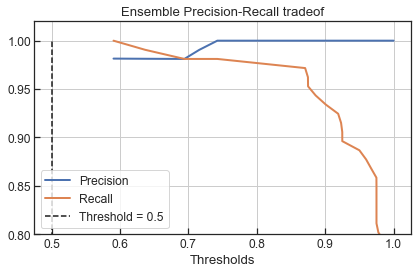

In [150]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('Ensemble Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.set_ylim(bottom=0.8, top=1.02)
ax.grid()
fig.tight_layout()
plt.savefig('Calibrate-VE.png', dpi=600)
plt.show()

In [151]:
# Determine a class from the predicted probability by using 
# the user-specified threshold value (not a default of 0.5)
THRESHOLD = 0.5  # fine-tuning
preds = np.where(y_test_scores > THRESHOLD, 1, 0)

In [152]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.roc_auc_score(y_test, preds),
                   metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "f1-score"], columns=['Values'])

,Values
accuracy,0.996795
recall,1.000000
precision,0.981481
roc_auc_score,0.998069
f1-score,0.990654


#### Computing environment

In [122]:
import sys, IPython, sklearn, scipy, matplotlib
print("Notebook createad with:\
      \nPython {:s}\nIPython {:s}\nScikit-learn {:s}\nPandas {:s}\nNumpy {:s}\nScipy {:s}\nMatplotlib {:s}"\
      .format(sys.version[:5], IPython.__version__, sklearn.__version__, pd.__version__, np.__version__, 
              scipy.__version__, matplotlib.__version__))

Notebook createad with:      
Python 3.7.3
IPython 7.9.0
Scikit-learn 0.21.3
Pandas 0.25.2
Numpy 1.17.3
Scipy 1.3.1
Matplotlib 3.1.1
